In [1]:
import sys

sys.path.append("..")

from copy import deepcopy
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBClassifier

from src.baseline_functions import *
from src.dips_selector import *
from src.data_loader import *


In [2]:
def quadrants(p, n_unlabeled, n_labeled, n_test, shift, random_state=42):
    """
    Quadrants data set
    """
    np.random.seed(random_state)
    X = []
    n_total = n_unlabeled + n_labeled + n_test
    for i in range(n_total):
        #first sample x<0 or x>0
        x = np.random.uniform(-1, 1)
        if x < 0:
            if np.random.uniform(0, 1) < p:
                y = np.random.uniform(-1,0) +shift
            else:
                y = np.random.uniform(0,1) + shift
        elif x >0 : 
            if np.random.uniform(0, 1) < p:
                y = np.random.uniform(0,1)
            else:
                y = np.random.uniform(-1,0)
        X.append([x,y])
    X = np.array(X)

    print(X.shape)
    y = np.zeros(n_unlabeled + n_labeled + n_test)
    y[X[:, 0] > 0] = 1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test, random_state=random_state)
    X_train, X_unlabeled, y_train, y_unlabeled = train_test_split(X_train, y_train, test_size=n_unlabeled, random_state=random_state)
    return X_train, y_train, X_unlabeled, y_unlabeled, X_test, y_test

# Main code 

In [4]:
import warnings
warnings.filterwarnings("ignore")

dataset_name = "quadrants"
prop_corruption_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
p = 0.
n_lab = 100
n_unlab = 900
shift = 0
n_trial = 20
pl_method = "pseudo"
seed=0 
nest=100
n_test = 50000
num_XGB_models=5
numIters=5 
upper_threshold=0.8 
verbose=False

#Data-IQ parameters
dips_ythresh = 0.2
dips_metric = "aleatoric"

#XGBoost parameters
param = {}
param["booster"] = "gbtree"
param["objective"] = "binary:logistic"
param["verbosity"] = 0
param["n_estimators"] = nest
param["silent"] = 1
param["seed"] = 42





#create a dataframe to store the results, where the columns are "prop_corruption", "trial", "accuracy", "method"
df_results = pd.DataFrame(columns=["prop_corruption", "trial", "accuracy", "method"])
for prop_corruption in prop_corruption_list:

    for trial in range(n_trial):
        #Load data
        seed +=1
        param["seed"] +=1
        #proportion is the proportion of labeled data in the training dataset (thus excluding the test se
        
        
       
            
           
            
        x_train, y_train, x_unlabeled, y_unlabeled, x_test, y_test = quadrants(
            p, n_unlab, n_lab, n_test, shift, random_state=seed
        )


        #Corrupting the labels of the training set
        y_train = np.array(y_train)
        
        #Generate the indices of corruption
        indices = np.arange(len(y_train))
        np.random.seed(seed)
        np.random.shuffle(indices)
        num_corrupted = int(len(indices)*prop_corruption)
        corrupted_indices = indices[:num_corrupted]
        non_corrupted_indices = indices[num_corrupted:]
        indicator_corrupted = np.zeros(len(y_train))
        indicator_corrupted[corrupted_indices] = 1
        y_train[corrupted_indices] = 1 - y_train[corrupted_indices]

        
        ##############################################################
        ########## SUPERVISED ########################################
        ##############################################################
        
        
        print("Training Supervised model...")
        # create XGBoost instance with default hyper-parameters
        xgb_sup = XGBClassifier(**param)

        xgb_sup.fit(x_train, y_train)

        # evaluate the performance on the test set
        y_test_pred = xgb_sup.predict(x_test)
        supervised_learning_accuracy = np.round(
            accuracy_score(y_test_pred, y_test) * 100, 2
        )  # round to 2 digits xx.yy %

        #add a row to the datafram
        df_results = df_results.append({"prop_corruption": prop_corruption, "trial": trial, "accuracy": supervised_learning_accuracy, "method": "naive supervised"}, ignore_index=True)

        # Run Data-IQ
        dips_xgb = DIPS_selector(X=x_train, y=y_train)

        for i in range(1, nest):
            # *** Characterize with Data-IQ [LINE 2] ***
            dips_xgb.on_epoch_end(clf=xgb_sup, iteration=i)

        # *** Access metrics ***
        if dips_metric == "aleatoric":
            dips_xmetric = dips_xgb.aleatoric
        elif dips_metric == "epistemic":
            dips_xmetric = dips_xgb.variability
        elif dips_metric == "entropy":
            dips_xmetric = dips_xgb.entropy
        elif dips_metric == "mi":
            dips_xmetric = dips_xgb.mi

        confidence = dips_xgb.confidence

        threshold = 0.75*(np.max(dips_xmetric) - np.min(dips_xmetric))
        #Now plot the distribution of dips_xmetric
        
        dips_xthresh = threshold


        easy_train, ambig_train, hard_train = get_groups(
            confidence=confidence,
            aleatoric_uncertainty=dips_xmetric,
            dips_xthresh=dips_xthresh,
            dips_ythresh=dips_ythresh,
        )


        selected_points = easy_train
        if len(easy_train) == 0:  #in some settings, i.e. no corruption, the threshold might be ill defined. Hence, we just take all the points
            selected_points = np.arange(len(y_train))
        
        
        if pl_method == "pseudo":
            (
                acc_vanilla,
                acc_dips_begin,
                acc_dips_full,
                acc_dips_partial,
                artifacts,
            ) = run_pseudo(
                x_unlabeled=x_unlabeled,
                x_test=x_test,
                y_test=y_test,
                x_train=x_train,
                y_train=y_train,
                numIters=numIters,
                #num_XGB_models=num_XGB_models,
                upper_threshold=upper_threshold,
                nest=nest,
                seed=seed,
                easy_train=selected_points,
                dips_metric=dips_metric,
                dips_xthresh=dips_xthresh,
                dips_ythresh=dips_ythresh,
                verbose=verbose
            )
        

        elif pl_method == "ups":
            (
                acc_vanilla,
                acc_dips_begin,
                acc_dips_full,
                acc_dips_partial,
                artifacts,
            ) = run_UPS(
                x_unlabeled=x_unlabeled,
                x_test=x_test,
                y_test=y_test,
                x_train=x_train,
                y_train=y_train,
                numIters=numIters,
                num_XGB_models=num_XGB_models,
                #upper_threshold=upper_threshold,
                nest=nest,
                seed=seed,
                easy_train=selected_points,
                dips_metric=dips_metric,
                dips_xthresh=dips_xthresh,
                dips_ythresh=dips_ythresh,
                verbose=verbose,
                weighting_rule = "hard",
                discard_ambig_hard = True
            )
        
        else:
            raise ValueError("pl_method must be either 'pseudo' or 'ups'")


      
        #add the four results to the dataframe
        df_results = df_results.append({"prop_corruption": prop_corruption, "trial": trial, "accuracy": acc_vanilla, "method": "vanilla"}, ignore_index=True)
        df_results = df_results.append({"prop_corruption": prop_corruption, "trial": trial, "accuracy": acc_dips_begin, "method": "dips_begin"}, ignore_index=True)
        df_results = df_results.append({"prop_corruption": prop_corruption, "trial": trial, "accuracy": acc_dips_full, "method": "dips_full"}, ignore_index=True)
        df_results = df_results.append({"prop_corruption": prop_corruption, "trial": trial, "accuracy": acc_dips_partial, "method": "dips_partial"}, ignore_index=True)
        



(51000, 2)
Training Supervised model...
===== Pseudo_Labeling
[44 56]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[36 51]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[36 51]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[44 56]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
(51000, 2)
Training Supervised model...
===== Pseudo_Labeling
[52 48]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[47 43]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[47 43]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[52 48]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
(51000, 2)
Training Supervised model...


In [5]:
#pickle the file
import pickle as pkl
with open("../artifacts/synthetic_results.pkl", "wb") as f:
    pkl.dump(df_results, f)

# Plot the comparison between the different methods

In [6]:
#load the file df_results.pkl as a variable df_results
df_results = pd.read_pickle("../artifacts/synthetic_results.pkl")

     prop_corruption trial  accuracy            method
0               0.10     0     92.42  naive supervised
1               0.10     0     96.06           vanilla
3               0.10     0     99.90         dips_full
5               0.10     1     98.40  naive supervised
6               0.10     1     98.37           vanilla
..               ...   ...       ...               ...
791             0.45    18     56.20           vanilla
793             0.45    18     56.62         dips_full
795             0.45    19     56.78  naive supervised
796             0.45    19     55.21           vanilla
798             0.45    19     69.50         dips_full

[480 rows x 4 columns]


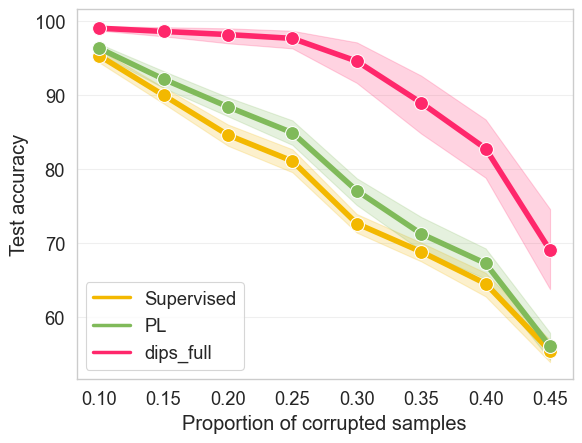

In [7]:
iteration_snapshot = -1
#For all rows in the dataframe, if the element in the accuracy column is a list, pick the first element
#copy the dataframe first
df_results2 = df_results.copy()
#remove the rows where the method is "dipss_begin" or dipssq_partial"
df_results2 = df_results2[~df_results2['method'].str.contains('dips_begin')]
df_results2 = df_results2[~df_results2['method'].str.contains('dips_partial')]




df_results2["accuracy"] = df_results2["accuracy"].apply(lambda x: x[iteration_snapshot] if type(x) == list else x)


#Plot the results in the dataframe, with the x axis being the prop_corruption and the y axis being the accuracy
sns.set_style("whitegrid")
custom_colors  = ["#F2B701", "#80BA5A", "#E73F74", ]
sns.set_context("paper", font_scale=1.5)
#set the color palette to somethin distinguishable
custom_palette = sns.color_palette("Set1", n_colors=8)
#custom_palette = sns.color_palette([sns.desaturate(color, 0.9) for color in custom_palette])
custom_colors = [sns.saturate(color) for color in custom_colors]
custom_colors[1] = "#80BA5A"
# Set the custom palette and line width
sns.set_palette(custom_colors)


plt.rcParams['lines.linewidth'] = 2.5



# Filter the data to get only the methods with "oracle" in their name
oracle_methods = df_results2[df_results2['method'].str.contains('oracle')]

print(df_results2[~df_results2['method'].str.contains('oracle')])

# Plot the non-oracle methods, the colors should be very intense
sns.lineplot(x="prop_corruption", y="accuracy", hue="method", data=df_results2[~df_results2['method'].str.contains('oracle')], linewidth=4, marker = "o", markersize = 10)


plt.xlabel("Proportion of corrupted samples")
plt.ylabel("Test accuracy")

handles, labels = plt.gca().get_legend_handles_labels()
labels = [label.replace("naive supervised", "Supervised") for label in labels]
labels = [label.replace("vanilla", "PL") for label in labels]
labels = [label.replace("dipss_full", "PL+DIPS (Ours)") for label in labels]

plt.legend(handles, labels)
#remove the vertical lines in the grid
plt.grid(False, axis='x')
#make the horizontal lines in the grid a bit more transparent
plt.gca().yaxis.grid(True, alpha=0.3)
#make the lines a bit thicker

plt.savefig("../artifacts/synthetic_plot.pdf", bbox_inches='tight')
plt.show()

# Now do the same stuff with Begin and partial for the ablation

     prop_corruption trial  accuracy        method
1               0.10     0     96.06       vanilla
2               0.10     0     99.59    dips_begin
3               0.10     0     99.90     dips_full
4               0.10     0     99.78  dips_partial
6               0.10     1     98.37       vanilla
..               ...   ...       ...           ...
794             0.45    18     57.18  dips_partial
796             0.45    19     55.21       vanilla
797             0.45    19     57.88    dips_begin
798             0.45    19     69.50     dips_full
799             0.45    19     58.76  dips_partial

[640 rows x 4 columns]


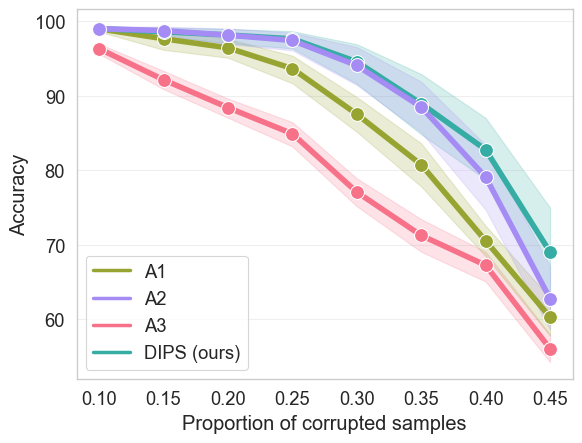

In [10]:
iteration_snapshot = -1
#For all rows in the dataframe, if the element in the accuracy column is a list, pick the first element
#copy the dataframe first
df_results2 = df_results.copy()


#remove the rows where prop_corruption is 0.5
df_results2 = df_results2[df_results2["prop_corruption"] != 0.5]


df_results2["accuracy"] = df_results2["accuracy"].apply(lambda x: x[iteration_snapshot] if type(x) == list else x)

#drop the rows where the 'method' is supervised
df_results2 = df_results2[~df_results2['method'].str.contains('supervised')]

#Plot the results in the dataframe, with the x axis being the prop_corruption and the y axis being the accuracy
sns.set_style("whitegrid")
custom_colors  = ["#F2B701", "#80BA5A", "#E73F74", ]
sns.set_context("paper", font_scale=1.5)
#set the color palette to somethin distinguishable
custom_palette = sns.color_palette("Set1", n_colors=8)
#custom_palette = sns.color_palette([sns.desaturate(color, 0.9) for color in custom_palette])
custom_colors = [sns.saturate(color) for color in custom_colors]
custom_colors[1] = "#80BA5A"
# Set the custom palette and line width
sns.set_palette(custom_colors)


plt.rcParams['lines.linewidth'] = 2.5



# Filter the data to get only the methods with "oracle" in their name
oracle_methods = df_results2[df_results2['method'].str.contains('oracle')]

print(df_results2[~df_results2['method'].str.contains('oracle')])

# Plot the non-oracle methods, the colors should be very intense
ax = sns.lineplot(x="prop_corruption", y="accuracy", hue="method", data=df_results2[~df_results2['method'].str.contains('oracle')], linewidth=4, ci=95, marker = "o", markersize = 10)

#change the x axis name to "Proportion of corrupted samples"
plt.xlabel("Proportion of corrupted samples")
plt.ylabel("Accuracy")

handles, labels = plt.gca().get_legend_handles_labels()
labels = [label.replace("vanilla", "A3") for label in labels]
labels = [label.replace("dips_begin", "A1") for label in labels]
labels = [label.replace("dips_partial", "A2") for label in labels]
labels = [label.replace("dips_full", "DIPS (ours)") for label in labels]

#order the legend in the order A1 A2 A3 DIPS
handles = [handles[1], handles[3], handles[0], handles[2]]
labels = [labels[1], labels[3], labels[0], labels[2]]

plt.legend(handles, labels)
#remove the vertical lines in the grid
plt.grid(False, axis='x')
#make the horizontal lines in the grid a bit more transparent
plt.gca().yaxis.grid(True, alpha=0.3)
#make the lines a bit thicker

#plt.title(f"Accuracy vs prop_corruption for p = {p} with n_lab = {n_lab}, n_unlab = {n_unlab}, n_test = {n_test}")
#save the figure in pdf format to the folder "artifacts", with the name "synthetic_plot.pdf"
plt.savefig("../artifacts/synthetic_plot_ablation.pdf", bbox_inches='tight')
plt.show()